In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import re

import warnings
warnings.filterwarnings('ignore')

Revision File

In [3]:
rev_df = pd.read_csv('D:/data/open_source/revision.csv.gz', header=None)
rev_df.columns = ['id', 'date', 'date_offset', 'committer_date', 'committer_date_offset', 'type', 'directory', 'message', 'author', 'committer']
rev_df = rev_df[['id', 'date']]

rev_df['id'] = rev_df['id'].apply(lambda x: x[2:])
rev_df['date'] = rev_df['date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.000Z'))

rev_df.head()

,id,date
0,01714ff5fd94a846f7dc3456a52e6f2dcd36ca0b,2015-04-02 01:11:50
1,01d76a45b817be788eab3e27a93e41c74a6d8957,2010-08-14 17:15:31
2,03ac0bf5d03af97bc7dc7c5aa67d8ee346f8cd1c,2013-09-27 17:02:55
3,05c9110ba2615d42af41a77138bc62dd18278320,2011-10-25 20:11:52
4,06de8d8e88d5b6311ea3feae369c85d157c9dfe3,2017-10-31 20:29:21


In [4]:
commit = pd.DataFrame()
commit['count'] = rev_df['date'].value_counts().resample('w').apply('count')
#commit['count'] = rev_df['date'].value_counts().resample('w').mean()
commit.head(25)

,count
1980-01-20,2
1980-01-27,0
1980-02-03,0
1980-02-10,0
1980-02-17,0
1980-02-24,0
1980-03-02,0
1980-03-09,0
1980-03-16,0
1980-03-23,0


NVD Files

In [4]:
#File Path
nvd_dir = 'D:/data/open_source/NVD/'

# File Type
nvd_file_type = '.json'

In [5]:
def date_str_nvd(st):
    return pd.to_datetime( st, format='%Y-%m-%dT%H:%MZ')

def score_nvd(json):
    if json['impact'] and 'baseMetricV2' in json['impact']:
        return json['impact']['baseMetricV2']['cvssV2']['baseScore']
    else:
        return 0.0

In [6]:
def import_nvd_clean(nvd_start=2, nvd_end=20):
    
    for i in range(nvd_start,nvd_end):
        
        year = '20'+str(i).zfill(2)
        path = nvd_dir+'nvdcve-1.1-'+year+nvd_file_type
        if i==nvd_start:
            nvd = clean_nvd(pd.read_json(path, encoding="utf8"))
        else:
            nvd = nvd.append( clean_nvd(pd.read_json(path, encoding="utf8")) )
    nvd = nvd.reset_index()
    return nvd.drop(['index'], 1)
    
def clean_nvd(nvd):
    nvd['date'] = nvd['CVE_Items'].apply( lambda x: date_str_nvd(x['publishedDate']) )
    nvd['score'] = nvd['CVE_Items'].apply( lambda x: score_nvd(x) )
    new_nvd = nvd.drop(['CVE_data_type','CVE_data_format','CVE_data_version','CVE_data_numberOfCVEs','CVE_data_timestamp','CVE_Items'], 1)
    return new_nvd

In [7]:
def vulnerability_resample(nvdDatabase, resample_by):
    return (nvdDatabase[['date','score']].set_index('date').resample(resample_by).max()).rename(columns={'score':'count'})

In [8]:
nvd_clean = import_nvd_clean()

In [9]:
nvd_cleanCopy = nvd_clean

In [10]:
nvd_cleanCopy.head(15)

,date,score
0,1999-12-30 05:00:00,5.0
1,1998-10-12 04:00:00,10.0
2,1998-04-01 05:00:00,10.0
3,1997-12-16 05:00:00,5.0
4,1998-07-20 04:00:00,10.0
5,1998-07-14 04:00:00,10.0
6,1998-06-26 04:00:00,5.0
7,1998-06-08 04:00:00,10.0
8,1998-04-08 04:00:00,10.0
9,1998-04-08 04:00:00,5.0


In [12]:
scoreMean = nvd_cleanCopy['score']
print("Overall mean of Base Score")
scoreMean.mean()

Overall mean of Base Score


5.754497175317594

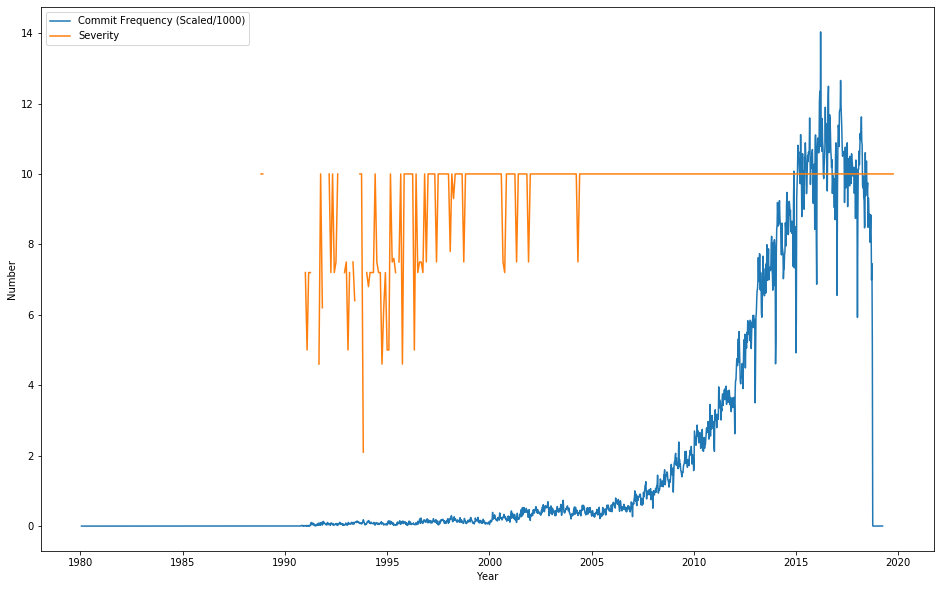

Severity(Weekly) vs. Frequency of Commits


In [13]:
plt.rcParams["figure.figsize"] = [16,10]

v_d = vulnerability_resample(nvd_cleanCopy,'m')
plt.plot(commit/1000, label="Commit Frequency (Scaled/1000)")
plt.plot(v_d, label="Severity")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Number")
plt.show()

print("Severity(Weekly) vs. Frequency of Commits")

The amount of commits over all increased year after year, so at the moment its does not seems like there is any if much link between the severity of a week and the frequency of commits (Note: Plot has been scaled)

Ofcourse this graph is going from 1980s to 2020, so it is very diffiult to see the small discrepecies, so lets looks a smaller area

In [15]:
begin = "1995-01-01"
end = "2000-12-30"
commitLimited = commit.truncate(before = begin, after = end)
nvd_cleanLimited = nvd_cleanCopy[(nvd_cleanCopy['date'] > begin) & (nvd_cleanCopy['date'] <= end)].reset_index(drop = True)

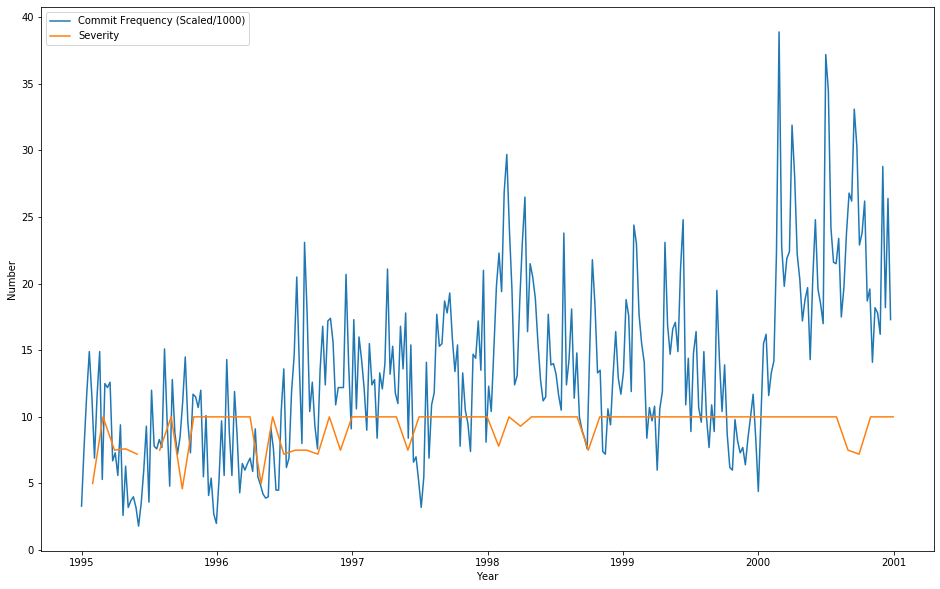

Severity(Weekly) vs. Frequency of Commits


In [17]:
plt.rcParams["figure.figsize"] = [16,10]

v_d2 = vulnerability_resample(nvd_cleanLimited,'m')
plt.plot(commitLimited/10, label="Commit Frequency (Scaled/1000)")
plt.plot(v_d2, label="Severity")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Number")
plt.show()

print("Severity(Weekly) vs. Frequency of Commits")

Looking at an area that had alot of fluctuations, the frequency of commits still seem to be any link (Note: Plot has been scaled)

(array([0.00065628, 0.00065628, 0.00131255, 0.00328138, 0.00721903,
        0.00656276, 0.00656276, 0.00328138, 0.00131255, 0.00196883,
        0.00065628, 0.00131255]),
 array([ 44.  ,  72.75, 101.5 , 130.25, 159.  , 187.75, 216.5 , 245.25,
        274.  , 302.75, 331.5 , 360.25, 389.  ]),
 <a list of 12 Patch objects>)

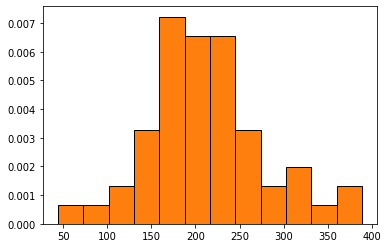

In [11]:
begin = "2000-01-01"
end = "2001-1-01"
commitLimited = commit.truncate(before = begin, after = end)
#commitLimited.hist(column='count', bins=12, ec='black', figsize=(12,8))
plt.hist(commitLimited['count'].values, bins=12, density=True, linestyle='solid', color = "C1", ec="black")